In [ ]:
!nvidia-smi

Sun Apr 17 09:34:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 8.1 MB/s 
     |████████████████████████████████| 10.1 MB 59.2 MB/s 
     |████████████████████████████████| 6.6 MB 49.7 MB/s 
     |████████████████████████████████| 4.0 MB 64.5 MB/s 
     |████████████████████████████████| 1.2 MB 62.6 MB/s 
     |████████████████████████████████| 325 kB 74.6 MB/s 
     |████████████████████████████████| 1.8 MB 52.9 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
     |████████████████████████████████| 181 kB 69.2 MB/s 
     |████████████████████████████████| 144 kB 75.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 136 kB 51.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 212 kB 75.0 MB/s 
     |██████████████

# Set Up Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_training = pd.read_csv('/content/drive/MyDrive/Wysdom/public_data_grammarfixed.csv', encoding='unicode_escape')
df_test = pd.read_csv('/content/drive/MyDrive/Wysdom/input_data_grammarfixed.csv')

In [ ]:
df_training.head()

,Unnamed: 0,Unnamed: 0.1,id,message,label,kmeans_cluster,intent,message_clean
0,0,0,8793,hi i want change my address from my credit card,updateaddress,14,to change my address,"Hi, I want to change my address from my credit..."
1,1,1,3083,i need 4 fruit maple oatmeal 3 cold brew froze...,orderdrinkintent,20,to eat breakfast,I need 4 fruit maple oatmeal 3 cold brew froze...
2,2,2,5932,i wish to travel next month domestic airway,bookflight,13,to travel,I wish to travel next month domestic airway.
3,3,3,12077,i need reimbursement my expenses,expensereport,20,to be reimbursed,I need reimbursement for my expenses.
4,4,4,6608,i need a copy of insurance for my car,getproofofinsurance,2,to be able to drive my car,I need a copy of insurance for my car.


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
encoded_labels = labelEncoder.fit_transform(df_training['label'])

In [ ]:
X = pd.concat([df_training['message_clean'].rename('text'), pd.Series(encoded_labels, name='labels')], axis=1)
X.head()

,text,labels
0,"Hi, I want to change my address from my credit...",34
1,I need 4 fruit maple oatmeal 3 cold brew froze...,20
2,I wish to travel next month domestic airway.,0
3,I need reimbursement for my expenses.,9
4,I need a copy of insurance for my car.,13


In [ ]:
n_labels = len(X.labels.value_counts())
n_labels

37

# Train Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs(num_train_epochs=7, train_batch_size=39, manual_seed=42, use_early_stopping=True, early_stopping_metric="mcc",
                                early_stopping_delta=0.003, early_stopping_metric_minimize=False, early_stopping_patience=5, evaluate_during_training_steps=1000,
                                reprocess_input_data=True, overwrite_output_dir=True)

model = ClassificationModel('roberta', 'roberta-base', use_cuda=True, num_labels=n_labels, args=model_args)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
model.train_model(X_train)
# model.train_model(X) # train with all data for production

  0%|          | 0/9298 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/239 [00:00<?, ?it/s]

(1673, 0.2772071542052994)

# Evaluate model on validation set

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
result, model_outputs, wrong_predictions = model.eval_model(X_val, ami=adjusted_mutual_info_score)

  0%|          | 0/2325 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

In [ ]:
result

{'ami': 0.9490728075005874,
 'eval_loss': 0.18532876583309107,
 'mcc': 0.9634311060930795}

# What did the model get wrong?

In [ ]:
incorrect_predictions = []

for prediction in wrong_predictions:
  incorrect_predictions.append(prediction.label) 

In [ ]:
incorrect_predictions_decoded = pd.Series(labelEncoder.inverse_transform(incorrect_predictions))

In [ ]:
incorrect_labels_counts = pd.Series(incorrect_predictions_decoded).value_counts()

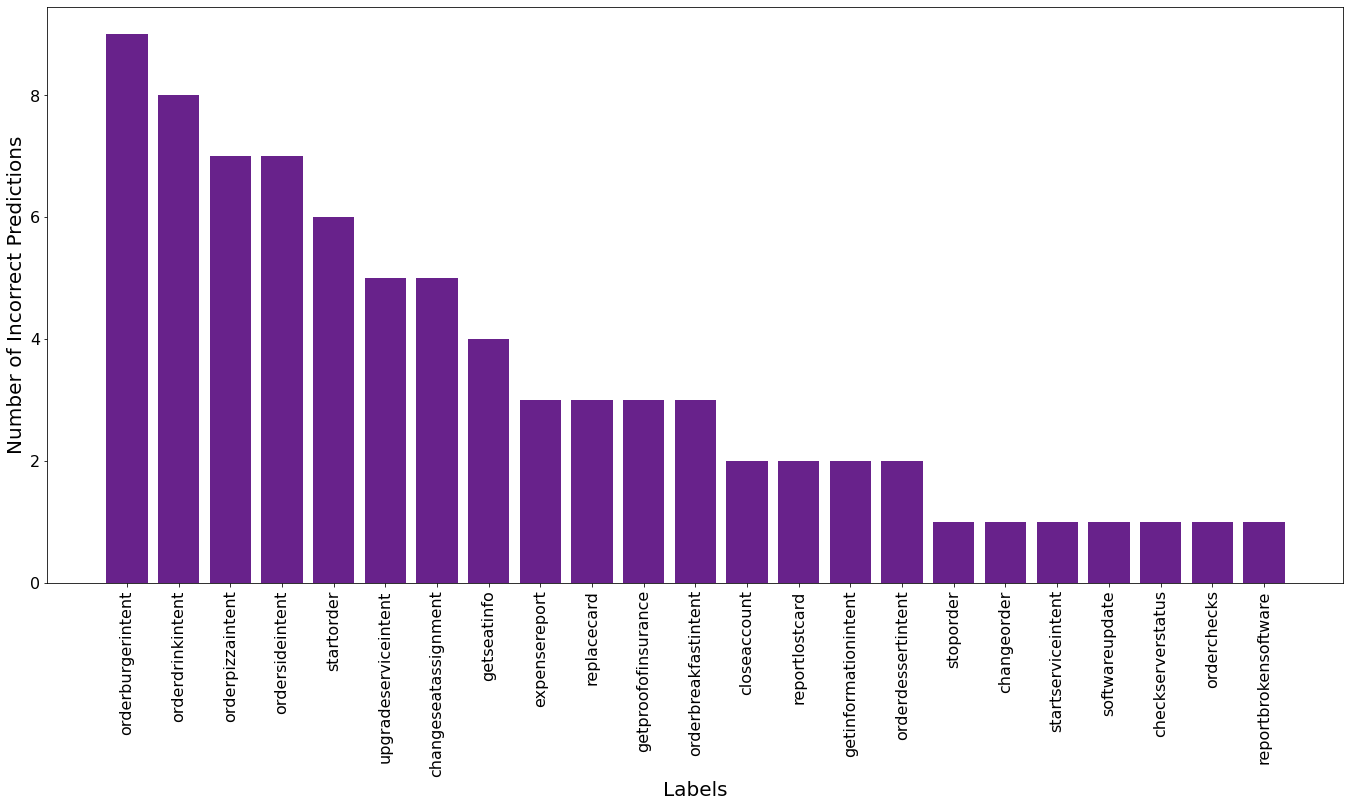

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
labels = list(incorrect_labels_counts.index)
count = incorrect_labels_counts.values
ax.bar(labels, count, color='#68228B')
ax.set_ylabel('Number of Incorrect Predictions', fontdict={'fontsize': 20})
ax.set_xlabel('Labels', fontdict={'fontsize': 20})
plt.xticks(rotation='vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("incorrect_val_preds_best.png", dpi=400)
plt.show()

# Confusion Matrix with Validation Set

In [ ]:
# get predicted labels from model_outputs
y_val = []

for output in model_outputs:
  y_val.append(output.argmax())

In [ ]:
y_val_decoded = labelEncoder.inverse_transform(y_val)
y_val_real = labelEncoder.inverse_transform(X_val['labels'])

In [ ]:
# Compare validation predictions with actual y_val
from sklearn.metrics import confusion_matrix, classification_report

classes = list(df_training['label'].value_counts().index)

cf_matrix = confusion_matrix(y_val_real, y_val_decoded, labels=classes)
print(cf_matrix)
print(classification_report(y_val_real, y_val_decoded))

[[329   0   0 ...   0   0   0]
 [  0 194   0 ...   0   0   0]
 [  0   0 189 ...   0   0   0]
 ...
 [  4   0   0 ...   0   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   3]]
                       precision    recall  f1-score   support

           bookflight       1.00      1.00      1.00        42
          changeorder       1.00      0.80      0.89         5
 changeseatassignment       0.91      0.91      0.91        57
         checkbalance       1.00      1.00      1.00        50
     checkclaimstatus       0.97      1.00      0.98        90
checkoffereligibility       1.00      1.00      1.00         6
    checkserverstatus       1.00      0.97      0.98        30
         closeaccount       0.95      0.90      0.92        20
        disputecharge       0.95      1.00      0.98        42
        expensereport       0.96      0.96      0.96        77
      getboardingpass       1.00      1.00      1.00       114
 getinformationintent       0.94      0.94      0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


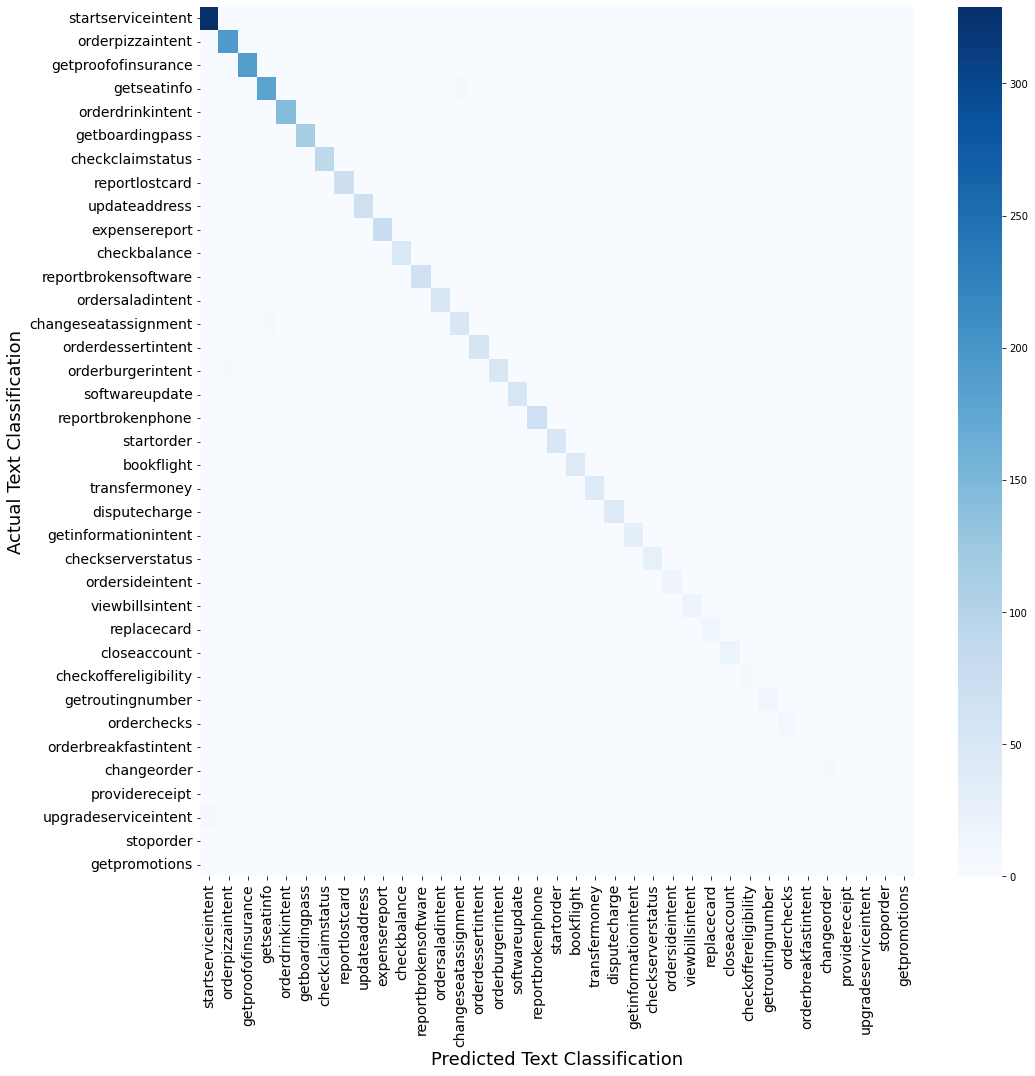

In [ ]:
# generate heat map
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(cf_matrix, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
ax.set_ylabel('Actual Text Classification', fontdict={'fontsize': 18})
ax.set_xlabel('Predicted Text Classification', fontdict={'fontsize': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("cfmatrix_best.png", dpi=400)
plt.show()

# Tuning

### Bayes Sweep

In [ ]:
import wandb

sweep_config = {
    "name": "roberta-base batch32",
    "method": "bayes",
    "metric": {"name": "adjusted_mutual_info_score", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 3, "max": 8},
        "learning_rate": {"min": 0.0, "max": 9e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6,},
}

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs

sweep_id = wandb.sweep(sweep_config, project="roberta-base no-batch tuning")

tuning_model_args = ClassificationArgs(train_batch_size=32, manual_seed=42, 
                                       reprocess_input_data=True, overwrite_output_dir=True, wandb_project="roberta-base no-batch tuning")

500 response executing GraphQL.
{"errors":[{"message":"Error 1040: Too many connections","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
500 response executing GraphQL.
{"error":"Error 1040: Too many connections"}
500 response executing GraphQL.
{"error":"Error 1040: Too many connections"}
Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/retry.py", line 102, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 147, in execute
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.7/dist-packages/six.py", line 703, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 141, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3

Create sweep with ID: mrohyjpe
Sweep URL: https://wandb.ai/kqmdjoh/roberta-base%20no-batch%20tuning/sweeps/mrohyjpe


In [ ]:
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: she6q1b7 with config:
wandb: 	learning_rate: 0.0003612154943221165
wandb: 	num_train_epochs: 8
wandb: Currently logged in as: kqmdjoh (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plot

Training loss,▄▂▃▃▃▁▄▄█▇▅▄▂▂▄▃▃▃█▄▆▃▃▃▃▃▃▃▁▂▂▂▂▂▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Training loss,0.10839
global_step,2300
lr,0.0


wandb: Agent Starting Run: mp66aava with config:
wandb: 	learning_rate: 0.000617692295907866
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1372530067089905}


Training loss,▁▁▂▂▄▆█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▆
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.00089
global_step,1700
lr,2e-05


wandb: Agent Starting Run: swid4ecc with config:
wandb: 	learning_rate: 2.3910546563327363e-05
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▄▃▃▂▁▂▁▁▁▂▁▁▁▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▆▆▅▅▄▄▃▃▃▂▁▁
Training loss,0.12411
global_step,850
lr,0.0


wandb: Agent Starting Run: rlm35d19 with config:
wandb: 	learning_rate: 0.0008976052775587532
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.138114966068071}


Training loss,▂▁██▆▇▇▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▆▆▅▅▄▄▃▃▃▂▁▁
Training loss,3.10001
global_step,850
lr,3e-05


wandb: Agent Starting Run: zikauf3u with config:
wandb: 	learning_rate: 0.0008582057107081806
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1387770823187027}


Training loss,▁▁▃█▆▇▇▇▇▆▇▇▇▇▇▇▇▆▆▇▇▇▇
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Training loss,3.20709
global_step,1150
lr,1e-05


wandb: Agent Starting Run: i6yf0xn7 with config:
wandb: 	learning_rate: 0.0003098495139241903
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▄▃▁▅▄▄▄▄▇▃▂▅▁▁▂▃▁▃▅▁▂▃▃▁▄▂▂
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.19349
global_step,1450
lr,0.0


wandb: Agent Starting Run: iy6mljou with config:
wandb: 	learning_rate: 3.870956977132281e-05
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▃▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,0.01854
global_step,1150
lr,0.0


wandb: Agent Starting Run: y52t3pju with config:
wandb: 	learning_rate: 0.00012463072564736563
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▂▃▁▃▂▃▁▃▂▂▂▁▁▂▁▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Training loss,0.00484
global_step,2300
lr,0.0


wandb: Agent Starting Run: 32giqvto with config:
wandb: 	learning_rate: 6.272330100086737e-05
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00428
global_step,2300
lr,0.0


wandb: Agent Starting Run: vw53khx8 with config:
wandb: 	learning_rate: 0.00017373839234189538
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▃▂▂▃▃▂▄▂▂▂▁▁▂▁▃▃▂▂▃▁▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
Training loss,0.00601
global_step,2300
lr,0.0


wandb: Agent Starting Run: os71fa1y with config:
wandb: 	learning_rate: 7.810011401375808e-05
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▂▂▂▂▂▂▁▁▃▁▁▂▁▁▁▁▁▂▁▁▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,0.06129
global_step,1150
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dx0tryu2 with config:
wandb: 	learning_rate: 0.0003961268883403955
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.9048271496211547, 'ami': 0.9047373432625235, 'eval_loss': 0.3705802379604877}


Training loss,▅▂▄▅▄▅▇▄▅▇▆▅▅▆▃▄▇█▄█▄▄▅▅▅▄▆▄▄▃▃▂▂▇▁▃▂▁▂▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.14958
global_step,2000
lr,1e-05


wandb: Agent Starting Run: vdyehpos with config:
wandb: 	learning_rate: 0.00039221099083435205
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.9314268152799057, 'ami': 0.9173459767388051, 'eval_loss': 0.3487178112837867}


Training loss,▄▁▃▃▂▂▃▂▄▄▆█▅▃▃▃▂▃▂▃▂▃▁▃▂▂▂▂▃▂▃▂▁▂
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.36899
global_step,1700
lr,1e-05


wandb: Agent Starting Run: ab9hfrua with config:
wandb: 	learning_rate: 0.0005310700628051459
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1362663765543517}


Training loss,▂▁▂▄▃▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁
Training loss,3.00122
global_step,2300
lr,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ar0vv5gy with config:
wandb: 	learning_rate: 0.0002534916555467257
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▄▅▃▂▃▃▃▂▄▂▃▂▁▂▂▃▁▂▃▁▂
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,0.13106
global_step,1150
lr,0.0


wandb: Agent Starting Run: 88dfek1t with config:
wandb: 	learning_rate: 0.0007014345476234125
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1368252993449315}


Training loss,▂▁▂█▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▆█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,3.00632
global_step,2300
lr,1e-05


wandb: Agent Starting Run: rnf5gldw with config:
wandb: 	learning_rate: 0.00047176628801410994
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.152266184911048, 'ami': 0.12281068948595743, 'eval_loss': 2.929096906045868}


Training loss,▂▁▁▃▂▁▃▃▃▆▃▃▆▇▇█▇▇▇█▇▇█
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,3.20415
global_step,1150
lr,1e-05


wandb: Agent Starting Run: 5kuhugwy with config:
wandb: 	learning_rate: 0.0004418624808569479
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.136849713079708}


Training loss,▃▁▂▂▁▂▃▂▇▅█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.00232
global_step,1700
lr,1e-05


wandb: Agent Starting Run: xbjq5pvs with config:
wandb: 	learning_rate: 0.00013402885371610035
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▂▂▂▃▂▂▃▂▂▂▁▁▂▁▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Training loss,0.00517
global_step,2300
lr,0.0


wandb: Agent Starting Run: wrqf19fi with config:
wandb: 	learning_rate: 0.0003430940990459976
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,▆▂▄▅▃▄▄▃▃▅▂▃█▂▃▄▃▂▄▂▂▄▂▅▃▅▃▂▁▄▁▃▂▂▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.02567
global_step,2300
lr,0.0


wandb: Agent Starting Run: 1766ufoe with config:
wandb: 	learning_rate: 0.0006967472913577982
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1372343813840464}


Training loss,▁▁▃█▆▆▇▆▇▆▇▇▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇█▆▇▇▆▆▆▇▇▆▇▆
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,3.077
global_step,2000
lr,1e-05


wandb: Agent Starting Run: ojckzoen with config:
wandb: 	learning_rate: 0.0006342261229981194
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.26633133056196096, 'ami': 0.20100372119391208, 'eval_loss': 2.780355154443852}


Training loss,▂▁▂▅█▇▇▆▇▆▇▇▇▆▇▇▆▆▆▇▆▇▇▇▇▇▇▆█▆▇▇▇▇▆█▆▅▆▆
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,2.68467
global_step,2000
lr,1e-05


wandb: Agent Starting Run: a6mf2y31 with config:
wandb: 	learning_rate: 0.00018452368874427905
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▃▁▂▃▃▂▃▁▂▂▁▂▂▁▃▃▁▂▂▂▂▂▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00773
global_step,2300
lr,0.0


wandb: Agent Starting Run: 8e4pmnyv with config:
wandb: 	learning_rate: 0.0004275799835029318
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1368570966818896}


Training loss,▂▁▂▂▁▁▂▂▃▂█▄▅▅▅▅▄▅▅▇▆▇▇▇▇▆▇▇█▇██▇▇▇█▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,3.07208
global_step,2000
lr,1e-05


wandb: Agent Starting Run: h97qqku7 with config:
wandb: 	learning_rate: 0.0006029985007237312
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.136835534957676}


Training loss,▂▁▂▃▄▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,3.59735
global_step,1450
lr,0.0


wandb: Agent Starting Run: oxyy3mww with config:
wandb: 	learning_rate: 0.0002366925372643095
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▃▃▂▅▄▃▂▁▄▂▄▂▁▂▁▂▁▃▄▁▂▂▃▂▃▁▂▃▁▂▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.04685
global_step,1700
lr,1e-05


wandb: Agent Starting Run: 4dkarkiy with config:
wandb: 	learning_rate: 0.0001986214915720442
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▃▃▂▂▃▃▂▂▃▂▂▂▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆██▇▇▆▆▅▄▄▄▃▃▂▂▁
Training loss,0.01703
global_step,850
lr,1e-05


wandb: Agent Starting Run: gziozcyq with config:
wandb: 	learning_rate: 0.0004110679681917317
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.136756839621108}


Training loss,▃▁▁▃▂▁▃▃▃▄▃▅▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Training loss,3.00888
global_step,2300
lr,1e-05


wandb: Agent Starting Run: cl8a2roq with config:
wandb: 	learning_rate: 0.0006327580640080339
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1377672960668086}


Training loss,▂▁▂▆▆▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,2.99329
global_step,2300
lr,1e-05


wandb: Agent Starting Run: d0bd45on with config:
wandb: 	learning_rate: 0.0007484576858487095
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.137402847460455}


Training loss,▂▁▃▄▆▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,2.99762
global_step,1700
lr,2e-05


wandb: Agent Starting Run: fxjxpifw with config:
wandb: 	learning_rate: 0.0002768566016232417
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▄▆▄▃▄▂▄▂▄▃▂▃▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆██▇▇▆▆▅▅▄▄▃▃▂▂▁
Training loss,0.07149
global_step,850
lr,1e-05


wandb: Agent Starting Run: ytfxkadb with config:
wandb: 	learning_rate: 0.0008507781052353599
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.137676687175056}


Training loss,▁▁▅█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.0054
global_step,1700
lr,2e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: isfdul8l with config:
wandb: 	learning_rate: 0.00012497515102096054
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▂▃▂▂▃▃▂▂▃▁▂▂▁▁▁▁▁▁▂▁▁▂▂▁▂▁▁
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.08928
global_step,1450
lr,0.0


wandb: Agent Starting Run: fakufjhx with config:
wandb: 	learning_rate: 0.0006076299536522934
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1361413698425817}


Training loss,▂▁▃▆▆▇▇▆▆▇▇▆▆▆▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Training loss,3.02179
global_step,2300
lr,1e-05


wandb: Agent Starting Run: g3yquf3b with config:
wandb: 	learning_rate: 0.0006858696725961084
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1382094338997124}


Training loss,▁▁▃▃▇██▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,3.22153
global_step,1150
lr,1e-05


wandb: Agent Starting Run: wzqlg7cm with config:
wandb: 	learning_rate: 0.0006619281383279779
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.138184768637431}


Training loss,▂▁▂█▆▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▆▇▇
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,3.07376
global_step,2000
lr,1e-05


wandb: Agent Starting Run: gor1mn2c with config:
wandb: 	learning_rate: 7.85640111066423e-05
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▂▂▂▁▂▂▂▁▃▂▂▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Training loss,0.06908
global_step,1150
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k601n3n6 with config:
wandb: 	learning_rate: 0.00046924852416885103
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.10116538534729892, 'ami': 0.13829147959854018, 'eval_loss': 2.8992789045641922}


Training loss,▃▁▂▃▂▃▃▆▇▇██▇█▇█▇▇▇█▆▇▇▇▇▇███▇▇▆▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,2.81104
global_step,1700
lr,1e-05


wandb: Agent Starting Run: tfhdz1i3 with config:
wandb: 	learning_rate: 9.886895495178368e-05
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▂▂▁▂▂▂▂▂▂▁▁▁▂▁▁▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00504
global_step,2300
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6eqhrh0l with config:
wandb: 	learning_rate: 0.0004469685415261515
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.9264118695984374, 'ami': 0.9131576171924638, 'eval_loss

Training loss,▆▂▄▅▃▅▆▆▇▃▅█▇▃▂▃▂▂▁▂▄▁▂
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,0.24831
global_step,1150
lr,1e-05


wandb: Agent Starting Run: la64zsce with config:
wandb: 	learning_rate: 0.0004145049117512149
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,▆▃▄▅▃▃█▇▄▄▄▂▄▄▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆██▇▇▆▅▅▅▄▃▃▂▂▂▁
Training loss,0.10437
global_step,850
lr,1e-05


wandb: Agent Starting Run: kbi7fbpg with config:
wandb: 	learning_rate: 0.0005955665669356235
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.1978342417604074, 'ami': 0.17841441226502103, 'eval_loss': 2.8211811285248327}


Training loss,▂▁▃▃▅██▇▇▇▇▇▇▇▇▇▆█▆▇▇▇▆▇▇█▇▇▆▆▆▇▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,2.77476
global_step,2300
lr,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jlqmnk5h with config:
wandb: 	learning_rate: 0.000270953734863853
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▅▄▂▃▃▄▃▁▄▂▂▂▁▁▃▂▂▃▂▁▃
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
Training loss,0.27751
global_step,1150
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vwi73t9p with config:
wandb: 	learning_rate: 0.0006214322996545976
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1367961033103393}


Training loss,▂▁▂▇▆▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Training loss,2.99973
global_step,2300
lr,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mirvafxs with config:
wandb: 	learning_rate: 0.0008051021520519162
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.138149866943097}


Training loss,▂▁▅█▆▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,2.99423
global_step,2300
lr,1e-05


wandb: Agent Starting Run: yc1019o4 with config:
wandb: 	learning_rate: 0.0008771261817184759
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.139056291776834}


Training loss,▂▁██▇▇█▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆██▇▇▆▆▅▅▄▄▃▃▂▂▁
Training loss,3.11572
global_step,850
lr,3e-05


wandb: Agent Starting Run: s3w5kjwx with config:
wandb: 	learning_rate: 0.0008898935927579957
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1379746899162373}


Training loss,▁▁██▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Training loss,3.22598
global_step,1150
lr,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jjzv0kj2 with config:
wandb: 	learning_rate: 0.0008326130018841538
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.13934909273259}


Training loss,▂▁██▆▇▇▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▇▆▅▅▄▄▃▃▂▂▁▁
Training loss,3.10229
global_step,850
lr,3e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uhuqk967 with config:
wandb: 	learning_rate: 0.00034758927525203203
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▅▄▄▃▃▅▅▃▄▅▃▃▆▂▁▂▄▁▂▅▂▃
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,▃▆██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Training loss,0.30806
global_step,1150
lr,0.0


wandb: Agent Starting Run: qztixgwc with config:
wandb: 	learning_rate: 0.0007150727849711285
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1369553398840204}


Training loss,▁▁▃▅▆▇▇▇▆▇▇▇▆▆▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▆█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Training loss,3.00345
global_step,2300
lr,1e-05


wandb: Agent Starting Run: 4uicshy6 with config:
wandb: 	learning_rate: 0.0005375199262627289
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.13782031921177}


Training loss,▂▁▂▂▁▂▄▆▇▆▇▇▇▆▇▆▆▆▆█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,2.99127
global_step,1700
lr,2e-05


wandb: Agent Starting Run: uy58mgqe with config:
wandb: 	learning_rate: 0.0007095259903378637
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1363279573696174}


Training loss,▂▁▃█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,3.57544
global_step,1450
lr,0.0


wandb: Agent Starting Run: ln2fo0r1 with config:
wandb: 	learning_rate: 0.00016408443648388614
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▃▂▂▂▃▃▃▂▂▂▁▁▃▁▂▄▂▂▃▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.00687
global_step,2300
lr,0.0


wandb: Agent Starting Run: fvobc275 with config:
wandb: 	learning_rate: 0.0006858754628600318
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.137379439835696}


Training loss,▁▁▃█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,3.61621
global_step,1450
lr,0.0


wandb: Agent Starting Run: jr7zi4hf with config:
wandb: 	learning_rate: 0.0004821414021608861
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,▄▂▃▄▂█▄▃▄▅▅▂▃▂▁▁▃
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▇▆▆▅▄▄▄▃▃▂▁▁
Training loss,0.49265
global_step,850
lr,2e-05


wandb: Agent Starting Run: 4pb5c9lx with config:
wandb: 	learning_rate: 0.0002515444640377945
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▄▄▂▂▅▃▅▂▄▅▃▃▁▁▂▄▃▃▃▃▃▄▃▁▅▃▂▂▃▂▁▂▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.01082
global_step,2000
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ysy582m2 with config:
wandb: 	learning_rate: 0.0003138446538513223
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▄▅▅▂▅▃▂▃▅▅▄▃▄▂▁▂▄▂▂▂▂▂▃▃▂▄▂▂▂▃▂▁▂
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.16563
global_step,1700
lr,1e-05


wandb: Agent Starting Run: edxdz3jo with config:
wandb: 	learning_rate: 0.00020491691907887692
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▄▃▅▃▃▁▃▃▃▂▂▃▁▁▁▃▁▂▄▂▂▂▃▁▂▂▂▂▁▂▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.01125
global_step,1700
lr,1e-05


wandb: Agent Starting Run: dp4kx8wd with config:
wandb: 	learning_rate: 0.0007995786082712577
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.17223226023360533, 'ami': 0.22231922802380497, 'eval_loss': 2.733867254453836}


Training loss,▂▁▃█▆▇▇▆▇▆▇▆▆▆▆▆▆▅▆▇▆▆▆▆▆▅▆▆▇▅▆▆▅▅▅▆▆▅▆▆
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,2.88094
global_step,2000
lr,2e-05


wandb: Agent Starting Run: bwsclka3 with config:
wandb: 	learning_rate: 0.0006757641794882409
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1366657268550386}


Training loss,▁▁▄▅▆▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
Training loss,3.0101
global_step,2300
lr,1e-05


wandb: Agent Starting Run: j11jt7k7 with config:
wandb: 	learning_rate: 0.0005042796224162875
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1368914101132}


Training loss,▂▁▂█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,2.99478
global_step,1700
lr,1e-05


wandb: Agent Starting Run: wmcy3yrh with config:
wandb: 	learning_rate: 0.00025689790794506583
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▅▄▂▄▃▂▃▂▄▃▂▃▁▃▁▄▁▂▂▁▂▂▂▁▃▁▂
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.16557
global_step,1450
lr,0.0


wandb: Agent Starting Run: 78a3ajj3 with config:
wandb: 	learning_rate: 0.0007372544159636754
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1397155551975944}


Training loss,▂▁▅█▆▇▇▇▇▇▇▇▇▇▇▇▇
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▆▆▅▅▄▄▃▃▃▂▂▁
Training loss,3.091
global_step,850
lr,2e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kuc35jxs with config:
wandb: 	learning_rate: 0.0002477471278340822
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▂▄▄▃▂▄▂▄▃▄▂▂▁▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆█▇▇▆▆▅▅▄▄▃▃▂▂▂▁
Training loss,0.08197
global_step,850
lr,1e-05


wandb: Agent Starting Run: 4hkmp5ux with config:
wandb: 	learning_rate: 0.000591110777491831
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1371828690427277}


Training loss,▂▁▂▂▄██▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,3.61603
global_step,1450
lr,0.0


wandb: Agent Starting Run: benyx979 with config:
wandb: 	learning_rate: 0.0003658186457475479
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classif

Training loss,▄▁▂▄▂▃▂▁█▁▃▂▃▃▁▁▃▂▁▂▃▁▁▂▂▁▂▂▁
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.23497
global_step,1450
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6k5qo4bt with config:
wandb: 	learning_rate: 0.0005960128316165774
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.137602857707702}


Training loss,▂▁▂▆▆██▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.00287
global_step,1700
lr,2e-05


wandb: Agent Starting Run: qgd957ij with config:
wandb: 	learning_rate: 0.000493000755825256
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.08202770582546572, 'ami': 0.05379581354829665, 'eval_loss': 3.0481613108382604}


Training loss,▂▁▂▃▃▄▄▄▄▆▆▆▆▇▇▇▇▇▇█▇█▇█▇▇▇▇█▇█▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,2.99866
global_step,1700
lr,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: puvn5a6k with config:
wandb: 	learning_rate: 0.0007124554052727861
wandb: 	num_train_epochs: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.137891967681675}


Training loss,▂▁▂▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▆▇▇
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,3.06348
global_step,2000
lr,1e-05


wandb: Agent Starting Run: 7g5shclb with config:
wandb: 	learning_rate: 0.00017867317377297446
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▃▂▃▂▃▂▃▂▂▂▁▁▂▂▂▃▂▂▃▁▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,▃▆███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
Training loss,0.00809
global_step,2300
lr,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aosm8ut1 with config:
wandb: 	learning_rate: 0.0005572685890717437
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1375288602822424}


Training loss,▂▁▃▂▃▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.00418
global_step,1700
lr,2e-05


wandb: Agent Starting Run: b5zj1obp with config:
wandb: 	learning_rate: 0.0006620570530346445
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1393551334892353}


Training loss,▁▁▂█▆▇▇▆▇▆▇▇▇▆▇▇▆
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,▃▆██▇▆▆▅▅▅▄▄▃▂▂▂▁
Training loss,3.0817
global_step,850
lr,2e-05


wandb: Agent Starting Run: k322bkrj with config:
wandb: 	learning_rate: 0.0006086530756624818
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1372874889177145}


Training loss,▂▁▃▂▅▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,3.01794
global_step,1700
lr,2e-05


wandb: Agent Starting Run: sj7y04bf with config:
wandb: 	learning_rate: 0.0003937051763439773
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.9220612165298335, 'ami': 0.9147448078505956, 'eval_loss': 0.32281066437613515}


Training loss,█▂▅▆▄▄██▅▄▆▆█▆▇▄▂▅▁▆▅▄▃▅▄▁▅▂▃
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.36383
global_step,1450
lr,0.0


wandb: Agent Starting Run: bwdl0ilc with config:
wandb: 	learning_rate: 0.0002666860784228903
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▄▅▃▃▃▂▄▃▄▂▃▂▂▂▂▂▁▂▆▂▁▃▄▁▄▂▂▂▂▁▁▂
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.18708
global_step,1700
lr,1e-05


wandb: Agent Starting Run: uzicssoz with config:
wandb: 	learning_rate: 9.577651273890828e-05
wandb: 	num_train_epochs: 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▃▂▂▂▂▂▂▁▃▂▂▁▁▁▂▁▁▁▂▁▁▂▂▁▂▁▁
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▄▆██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Training loss,0.06265
global_step,1450
lr,0.0


wandb: Agent Starting Run: enl5mtso with config:
wandb: 	learning_rate: 0.00031375545686235923
wandb: 	num_train_epochs: 6


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/291 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▃▄▄▃▅▄▅▃▄▇▃▄▂▂▂▄▄▄▄▇▃▂▃▄▁▄▂▃▂▃▃▁▃
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,▃▆███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Training loss,0.2761
global_step,1700
lr,1e-05


wandb: Agent Starting Run: ft1xobgr with config:
wandb: 	learning_rate: 0.0006220907997780212
wandb: 	num_train_epochs: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


### Random Sweep

In [ ]:
import math

sweep_config = {
    "name": "roberta-base random",
    "method": "random",
    #"metric": {"name": "adjusted_mutual_info_score", "goal": "maximize"},
    
    "parameters": {
        "num_train_epochs": {"distribution": "int_uniform", "min": 1, "max": 10},
        "learning_rate": {"distribution": "uniform", "min": 5e-5, "max": 5e-4},
        "train_batch_size": {"distribution": "int_uniform", "min": 4, "max": 128}
    },
}

In [ ]:
# Random search sweep
import wandb
from sklearn.metrics.cluster import adjusted_mutual_info_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs

random_sweep_id = wandb.sweep(sweep_config, project="roberta-base random tuning")

random_tuning_model_args = ClassificationArgs(manual_seed=42, 
                                       reprocess_input_data=True, overwrite_output_dir=True, wandb_project="roberta-base random tuning")

Create sweep with ID: 5ruo7rm4
Sweep URL: https://wandb.ai/kqmdjoh/roberta-base%20no-batch%20random%20tuning/sweeps/5ruo7rm4


In [ ]:
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

def train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        use_cuda=True,
        num_labels=n_labels,
        args=random_tuning_model_args,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(X_train)

    # Evaluate the model
    model.eval_model(X_val, ami=adjusted_mutual_info_score)

    # Sync wandb
    wandb.join()

In [ ]:
wandb.agent(random_sweep_id, train, count=15)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=15
wandb: Agent Starting Run: 0ngqwz9r with config:
wandb: 	learning_rate: 0.00019781020001691433
wandb: 	num_train_epochs: 9
wandb: 	train_batch_size: 69
wandb: Currently logged in as: kqmdjoh (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 1 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 2 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 3 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 4 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 5 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 6 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 7 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 8 of 9:   0%|          | 0/135 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plot

Training loss,█▆▃▃▄▄▂▃▂▃▂▂▃▁▃▁▁▁▁▁▂▁▂▁
global_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
lr,▆██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
Training loss,0.01111
global_step,1200
lr,0.0


wandb: Agent Starting Run: xqtwzm04 with config:
wandb: 	learning_rate: 0.000641393208117172
wandb: 	num_train_epochs: 6
wandb: 	train_batch_size: 7


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1329 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'ami': 4.888130006349623e-17, 'eval_loss': 3.1376760161619415}


Training loss,▅▆▇▅▇▆▇▄▆▇▆▅▅▅█▁▅▃▇▆▅▆▂▂▆▆▆▅▅▆▅▃▇▄▆▆▇▅▅█
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Training loss,3.27818
global_step,7950
lr,0.0


wandb: Agent Starting Run: wxyfup05 with config:
wandb: 	learning_rate: 0.000804301783144908
wandb: 	num_train_epochs: 2
wandb: 	train_batch_size: 52


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,█▅▄▄▂▁▁
global_step,▁▂▃▅▆▇█
lr,▆█▇▅▄▂▁
Training loss,0.54381
global_step,350
lr,2e-05


wandb: Agent Starting Run: wv5jxikh with config:
wandb: 	learning_rate: 7.29721295758908e-05
wandb: 	num_train_epochs: 1
wandb: 	train_batch_size: 97


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/9298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_37_2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/96 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2325 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_37_2


Running Evaluation:   0%|          | 0/291 [00:00<?, ?it/s]

wandb: WARNING using only the first 1000 datapoints to create chart confusion_matrix
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000

Training loss,▁
global_step,▁
lr,▁
Training loss,1.23687
global_step,50
lr,5e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tygi5tkn with config:
wandb: 	learning_rate: 0.0004979562748154357
wandb: 	num_train_epochs: 6
wandb: 	train_batch_size: 85
wandb: Ctrl + C detected. Stopping sweep.


# Make Predictions on Test Set

In [ ]:
X_test = df_test['message'].rename('text')
predictions, raw_outputs = model.predict(X_test.values.tolist())

  0%|          | 0/2906 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

In [ ]:
transformed_predictions = labelEncoder.inverse_transform(predictions)

## Write predictions to zip for submission

In [ ]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': transformed_predictions})
print(my_submission.head())

      Id                 label
0  12123  reportbrokensoftware
1    244      orderpizzaintent
2   8221           replacecard
3  12856    startserviceintent
4  12108         expensereport


In [ ]:
compression_opts = dict(method='zip', archive_name='coda_submission.csv')
my_submission.to_csv('robertabase_grammarfixed_submission.zip', index=False, compression=compression_opts)